In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

# Scipy gaussian kernel estimation

Scipy comes with gaussian KDE out of the box: [`scipy.stats.gaussian_kde`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html).  As the docs say:

>  It includes automatic bandwidth determination. The estimation works best for a unimodal distribution; bimodal or multi-modal distributions tend to be oversmoothed.

For multi-dimensional data, the convention is:

> ... otherwise a 2-D array with shape (# of dims, # of data).

In [2]:
data = np.random.normal(loc=2.0, scale=1.5, size=20)

kernel = scipy.stats.gaussian_kde(data)

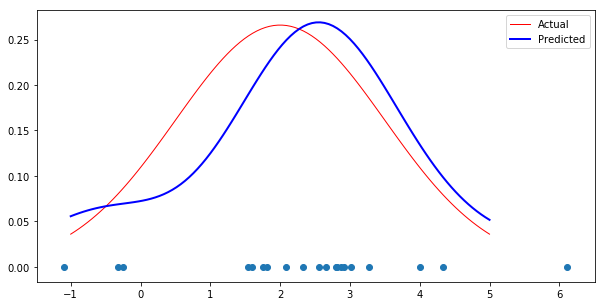

In [3]:
fig, ax = plt.subplots(figsize=(10,5))

x = np.linspace(-1, 5, 100)

var = 2 * 1.5 ** 2
y = np.exp(-(x-2)**2/var) / np.sqrt(var * np.pi)
ax.plot(x, y, color="red", linewidth=1)

y = kernel(x)
ax.plot(x, y, color="blue", linewidth=2)
_ = ax.legend(["Actual", "Predicted"])
_ = ax.scatter(data, [0] * data)

## Two dimensional case

This example is from the scipy docs

In [4]:
def measure(n):
    m1 = np.random.normal(size=n)
    m2 = np.random.normal(scale=0.5, size=n)
    return m1 + m2, m1 - m2

def actual_kernel(point):
    x, y = point[0], point[1]
    # m2 = 0.5 * np.random.normal
    # Transform matrix is: A = 1  1/2
    #                          1 -1/2
    # So covariance matrix is AA^* = 5/4  3/4
    #                                3/4  5/4
    a = x * (5 * x - 3 * y) / 4 + y * (-3 * x + 5 * y) / 4
    return np.exp(-a/2) / 2*np.pi

m1, m2 = measure(2000)
xmin, xmax = min(m1), max(m1)
ymin, ymax = min(m2), max(m2)

data_2d = np.vstack([m1, m2])
kernel_2d = scipy.stats.gaussian_kde(data_2d)

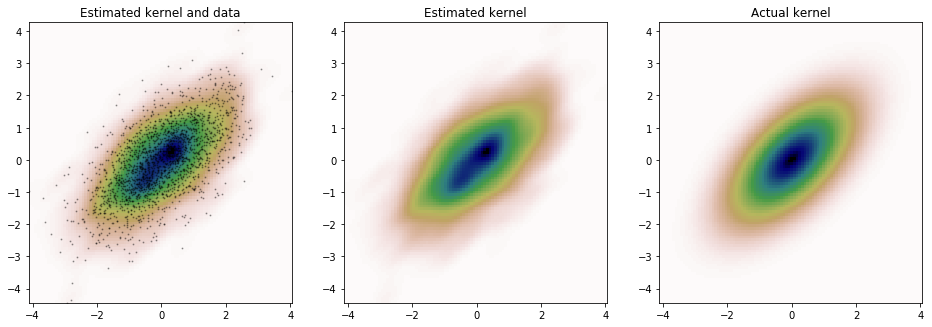

In [5]:
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel_2d(positions).T, X.shape)
Z_actual = np.reshape(actual_kernel(positions).T, X.shape)

fig, ax = plt.subplots(ncols=3, figsize=(16,10))

for i, z in enumerate([Z, Z, Z_actual]):
    ax[i].imshow(np.rot90(z), cmap=plt.cm.gist_earth_r, extent=[xmin, xmax, ymin, ymax])
    ax[i].set_aspect(1)
ax[0].plot(m1, m2, 'k.', markersize=2, alpha=0.3)
ax[0].set_title("Estimated kernel and data")
ax[1].set_title("Estimated kernel")
ax[2].set_title("Actual kernel")
None

# Nearest neighbour bandwidth selection

This algorithm is described in Mohler et al, "Self-Exciting Point Process Modeling of Crime", Journal of the American Statistical Association, 2011 doi:10.1198/jasa.2011.ap09546.  See the Appendix.

Suppose we have data points $(x_i)$ where each $x_i = (x^{(i)}_1, \cdots, x^{(i)}_n)$ is a vector.  Fix an integer $k$.

   1. Let $\sigma_i^2$ be the sample variance for each coordinate
   2. Scale each coordinate by $\sigma_i$.
   3. For the scaled data, let $D_j$ be the distance from point $j$ to the $k$th nearest neighbour in the scaled dataset
   3. Each point $j$ in coordinate $i$ will the contribute a gaussian kernel centred at $x^{(j)}_i$ and with variance $D_j \sigma_i$.
   4. Thus the total estimated kernel is
   $$ k(x) = \frac{1}{N} \sum_{j=1}^N \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma_i^2 D_j^2}} \exp\Big(
   - \frac{(x_i - x^{(j)}_i)^2}{2\sigma_i^2D_j^2} \Big) $$

In [6]:
import open_cp.kernels

In [7]:
def plot_1d_knn(ax, k):
    kth_kernel_1d = open_cp.kernels.kth_nearest_neighbour_gaussian_kde(data, k=k)
    x = np.linspace(-1, 5, 100)

    var = 2 * 1.5 ** 2
    y = np.exp(-(x-2)**2/var) / np.sqrt(var * np.pi)
    ax.plot(x, y, color="red", linewidth=1)

    y = kth_kernel_1d(x)
    ax.plot(x, y, color="blue", linewidth=2)
    ax.legend(["Actual", "Predicted"])
    ax.scatter(data, data * 0, alpha=0.5)
    ax.set_title("Using k={}".format(k))

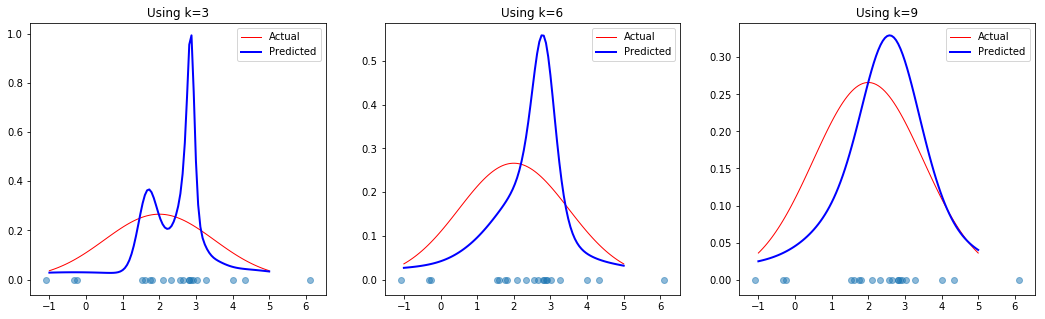

In [8]:
fig, ax = plt.subplots(ncols=3, figsize=(18,5))

plot_1d_knn(ax[0], 3)
plot_1d_knn(ax[1], 6)
plot_1d_knn(ax[2], 9)

In the one dimensional case, we don't need to rescale the data, so we can visualise easily what happens.  Let's look at $k=6$

What we end up with is a load of gaussian curves, one for each data point, centred at that data point, and with a variance chosen so that, in this case, the 6 nearest neighbours lie in one standard deviation.  We then take the average to get our estimated kernel.

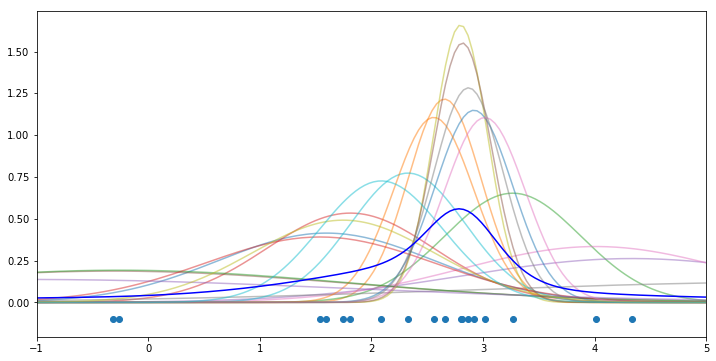

In [9]:
def distances(pts, point):
    dists = [abs(x - point) for x in pts]
    dists.sort()
    return dists

dists = [ distances(data, x)[6] for x in data ]

fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(-1, 5, 150)

yy = np.zeros_like(x)
for pt, d in zip(data, dists):
    y = scipy.stats.norm(loc=pt, scale=d).pdf(x)
    yy += y
    ax.plot(x, y, alpha=0.5)

ax.plot(x, yy/len(data), color="blue")
clamped = data[ (-1<=data) & (data<=5) ]
ax.scatter(clamped, [-0.1 for _ in clamped])
ax.set(xlim=[-1,5])
None

## Two dimensional case

Here with $k=20$ which is probably somewhat too small for this data.

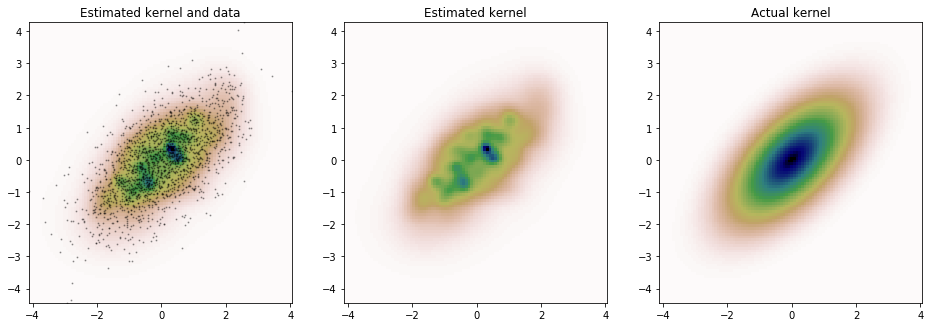

In [10]:
kth_kernel_2d = open_cp.kernels.kth_nearest_neighbour_gaussian_kde(data_2d, k=20)

X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kth_kernel_2d(positions).T, X.shape)

fig, ax = plt.subplots(ncols=3, figsize=(16,10))

for i, z in enumerate([Z, Z, Z_actual]):
    ax[i].imshow(np.rot90(z), cmap=plt.cm.gist_earth_r, extent=[xmin, xmax, ymin, ymax])
    ax[i].set_aspect(1)
ax[0].plot(m1, m2, 'k.', markersize=2, alpha=0.3)
ax[0].set_title("Estimated kernel and data")
ax[1].set_title("Estimated kernel")
ax[2].set_title("Actual kernel")
None

One downside to this algorithm is that it is rather slow: the resulting kernel takes $O(Nk)$ to evaluation, with $N$ data points and $k$ dimensions.

# Computing marginals

In the analysis of the kernels produced, it is often useful to compute marginals-- i.e. integrate out all but one variable.  This is slow to do numerically, but given the special form of the kernel, quite easy to calculate explicity.

The kernel is
$$ k(x) = \frac{1}{N} \sum_{j=1}^N \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma_i D_j}} \exp\Big(
   - \frac{(x_i - x^{(j)}_i)^2}{2\sigma_i^2D_j^2} \Big) $$

If we (without loss of generality) integrate out all but the first variable, as everything is independent and a normalised Gaussian, we get
$$ \int \cdots \int k((x_1,\cdots,x_n)) \ d x_2 \cdots \ d x_n =
\frac{1}{N} \sum_{j=1}^N \frac{1}{\sqrt{2\pi\sigma_1^2 D_j^2}} \exp\Big(
   - \frac{(x_1 - x^{(j)}_1)^2}{2\sigma_1^2D_j^2} \Big) $$

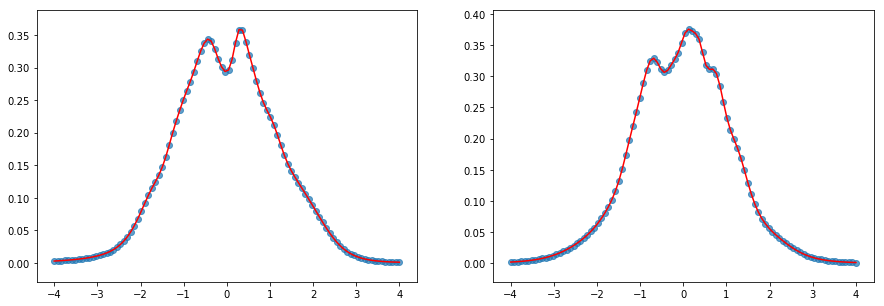

In [11]:
import scipy.integrate

def x_marginal(kernel, x):
    return scipy.integrate.quad(lambda y : kernel([x,y]), -5, 5)[0]
def y_marginal(kernel, y):
    return scipy.integrate.quad(lambda x : kernel([x,y]), -5, 5)[0]

fig, ax = plt.subplots(ncols=2, figsize=(15,5))

x = np.linspace(-4, 4, 100)
inted = [x_marginal(kth_kernel_2d, xx) for xx in x]
ax[0].scatter(x, inted, alpha=0.7)
marginal = open_cp.kernels.marginal_knng(data_2d, 0, k=20)
comp = marginal(x)
ax[0].plot(x, comp, color="red")

inted = [y_marginal(kth_kernel_2d, xx) for xx in x]
ax[1].scatter(x, inted, alpha=0.7)
marginal = open_cp.kernels.marginal_knng(data_2d, 1, k=20)
comp = marginal(x)
ax[1].plot(x, comp, color="red")
None

# Example from Mohler et al.

We sample from a three dimensional kernel:
$$ g(t,x,y) = \frac{\omega}{2\pi\sigma_x\sigma_y} \exp(-\omega t) \exp\Big(-\frac{x^2}{2\sigma_x^2}\Big)\exp\Big(-\frac{y^2}{2\sigma_y^2}\Big) $$
with parameters $\sigma_x=0.01, \sigma_y=0.1, \omega^{-1}=10$.

Let us start with a small sample, and k=20.

In [12]:
def space_time_sample(length=1):
    t = np.random.exponential(10, size=length)
    x = np.random.normal(scale=0.01, size=length)
    y = np.random.normal(scale=0.1, size=length)
    return np.vstack([t,x,y])

data_3d = space_time_sample(100)
kth_kernel_3d = open_cp.kernels.kth_nearest_neighbour_gaussian_kde(data_3d, k=20)

In [13]:
def plot_actual_marginals():
    def actual_t_marginal(t):
        return np.exp(-t/10)/10
    def actual_x_marginal(x):
        return np.exp(-x*x/(2*0.01**2)) / np.sqrt(2*np.pi*0.01**2)
    def actual_y_marginal(y):
        return np.exp(-y*y/(2*0.1**2)) / np.sqrt(2*np.pi*0.1**2)

    fig, ax = plt.subplots(ncols=3, figsize=(16,5))

    tc = np.linspace(0,60,100)
    actual = actual_t_marginal(tc)
    ax[0].plot(tc, actual, color="red", linewidth=1)

    xc = np.linspace(-0.05,0.05,100)
    actual = actual_x_marginal(xc)
    ax[1].plot(xc, actual, color="red", linewidth=1)

    yc = np.linspace(-0.5,0.5,100)
    actual = actual_y_marginal(yc)
    ax[2].plot(yc, actual, color="red", linewidth=1)

    return ax

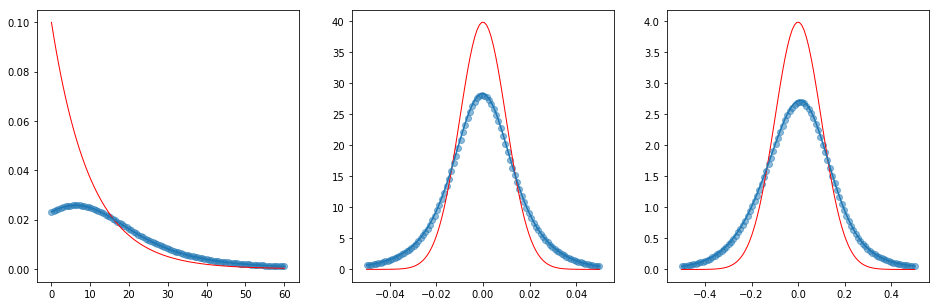

In [14]:
def tx_marginal(t, x):
    return scipy.integrate.quad(lambda y : kth_kernel_3d([t,x,y]), -1, 1)[0]
def ty_marginal(t, y):
    return scipy.integrate.quad(lambda x : kth_kernel_3d([t,x,y]), -0.2, 0.2)[0]
def t_marginal(t):
    return scipy.integrate.quad(lambda x : tx_marginal(t, x), -0.2, 0.2)[0]
def x_marginal(x):
    return scipy.integrate.quad(lambda t : tx_marginal(t, x), -30, 100)[0]
def y_marginal(y):
    return scipy.integrate.quad(lambda t : ty_marginal(t, y), -30, 100)[0]

def plot_calculated_estimated_marginals(ax, data, k):
    tc = np.linspace(0,60,100)
    ax[0].plot(tc, open_cp.kernels.marginal_knng(data, 0, k)(tc))
    xc = np.linspace(-0.05,0.05,100)
    ax[1].plot(xc, open_cp.kernels.marginal_knng(data, 1, k)(xc))
    yc = np.linspace(-0.5,0.5,100)
    ax[2].plot(yc, open_cp.kernels.marginal_knng(data, 2, k)(yc))
    return tc, xc, yc

ax = plot_actual_marginals()
tc, xc, yc = plot_calculated_estimated_marginals(ax, data_3d, k=20)

actual = [t_marginal(t) for t in tc]
ax[0].scatter(tc, actual, alpha=0.5)

actual = [x_marginal(x) for x in xc]
ax[1].scatter(xc, actual, alpha=0.5)

actual = [y_marginal(y) for y in yc]
ax[2].scatter(yc, actual, alpha=0.5)
None

We see very good agreement between the numerical integration and the calculated marginals.

However, we see rather _poor_ estimation of the actual kernels!

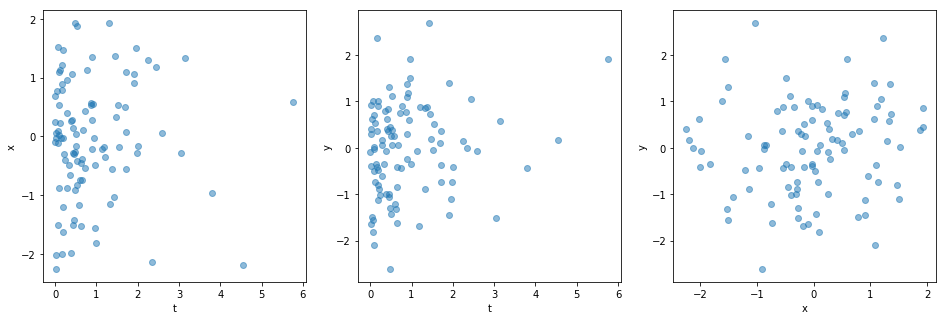

In [15]:
def two_dim_slices(pts, alpha=0.5):
    fig, ax = plt.subplots(ncols=3, figsize=(16,5))
    ax[0].scatter(pts[0], pts[1], alpha=alpha)
    ax[0].set(xlabel="t", ylabel="x")
    ax[1].scatter(pts[0], pts[2], alpha=alpha)
    ax[1].set(xlabel="t", ylabel="y")
    ax[2].scatter(pts[1], pts[2], alpha=alpha)
    ax[2].set(xlabel="x", ylabel="y")

normalised = data_3d / np.std(data_3d, axis=1, ddof=1)[:,None]
two_dim_slices(normalised)

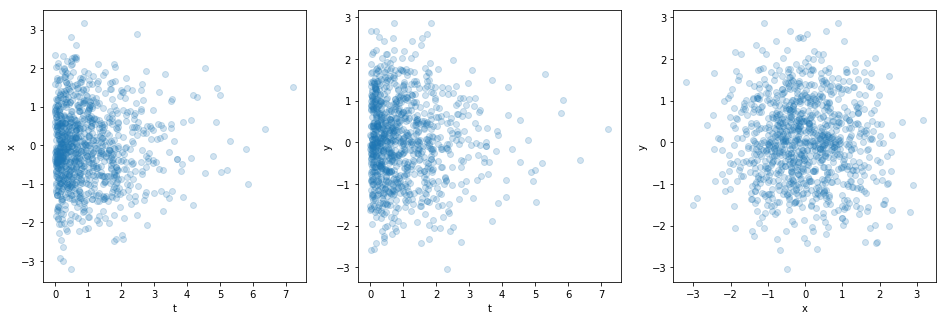

In [16]:
data_3d = space_time_sample(1000)
normalised = data_3d / np.std(data_3d, axis=1, ddof=1)[:,None]
two_dim_slices(normalised, alpha=0.2)

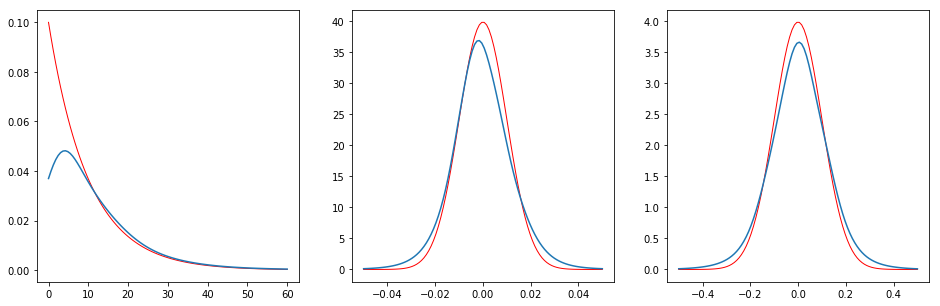

In [17]:
kth_kernel_3d = open_cp.kernels.kth_nearest_neighbour_gaussian_kde(data_3d, k=20)
ax = plot_actual_marginals()
_ = plot_calculated_estimated_marginals(ax, data_3d, k=20)

With 10000 samples (not shown), the x and y marginals show excellent agreement.

The moral of the story here is that this sort of general purpose KDE may not be appropriate for certain models.